In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# Data
from ucimlrepo import fetch_ucirepo

# Quantum
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
from qiskit_aer import AerSimulator
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.algorithms import PegasosQSVC
from qiskit_algorithms.optimizers import SPSA
from qiskit.primitives import Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit import QuantumCircuit
from qiskit.circuit.library import BlueprintCircuit

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

In [21]:
wine = fetch_ucirepo(id=109)

In [32]:
X = wine.data.features
y = wine.data.targets

## Angle Encoding

In [70]:
X_array = X.to_numpy()
n_qubits = X_array.shape[1]
qc = QuantumCircuit(n_qubits)
for row in X_array:
    for i, feature in enumerate(row):
        qc.ry(feature * np.pi, i)

print(qc)

   ┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐»
q: ┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├»
   └───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘»
«   ┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐»
«q: ┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├»
«   └───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘»
«   ┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐»
«q: ┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├»
«   └───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘»
«   ┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐»
«q: ┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├┤ Ry(π) ├»
«   └───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘»
«   ┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐

# Pre-Processing of data

In [33]:
# Separating features for both datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((142, 13), (36, 13))

# Quantum Support Vector Machine

In [35]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

feature_map = ZZFeatureMap(
    feature_dimension = X_train.shape[1],
    reps = 1,
    entanglement = 'full'
)

sampler = Sampler()

# Subroutine that leverages the Sampler primitive
fidelity = ComputeUncompute(sampler=sampler)

kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map) 

# Selecting a simulating method
quantum_instance = AerSimulator(method='statevector', shots = 1024)

qsvc = QSVC(quantum_kernel=kernel, max_iter=100)

print("Training QSVM...")
qsvc.fit(X_train, y_train)

qsvc_score = qsvc.score(X_test, y_test)
print("QSVC Score:", qsvc_score)

y_pred = qsvc.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/var/folders/pf/wyb5vhpd027g120tcw057sb80000gn/T/ipykernel_13806/1448282465.py:12: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/var/folders/pf/wyb5vhpd027g120tcw057sb80000gn/T/ipykernel_13806/1448282465.py:15: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  fidelity = ComputeUncompute(sampler=sampler)
/Users/fibu/anaconda3/envs/jupyterlab/lib/python3.12/site-packages/sklearn/svm/_base.py:737: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

Training QSVM...


/Users/fibu/anaconda3/envs/jupyterlab/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


QSVC Score: 0.9722222222222222

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.93      0.96        14
           2       0.94      1.00      0.97        16
           3       1.00      1.00      1.00         6

    accuracy                           0.97        36
   macro avg       0.98      0.98      0.98        36
weighted avg       0.97      0.97      0.97        36



In [43]:
quantum_error_rate = 1 - accuracy_score(y_test, y_pred)
print(f"Quantum SVM Error Rate: {quantum_error_rate:.2f}")

Quantum SVM Error Rate: 0.03


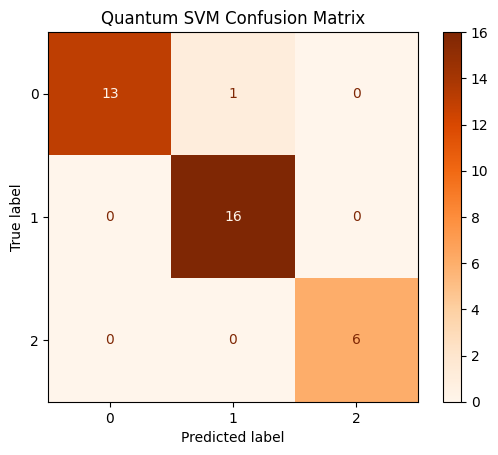

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_quantum = confusion_matrix(y_test, y_pred)
disp_quantum = ConfusionMatrixDisplay(confusion_matrix=cm_quantum)
disp_quantum.plot(cmap='Oranges')
plt.title('Quantum SVM Confusion Matrix')
plt.show()

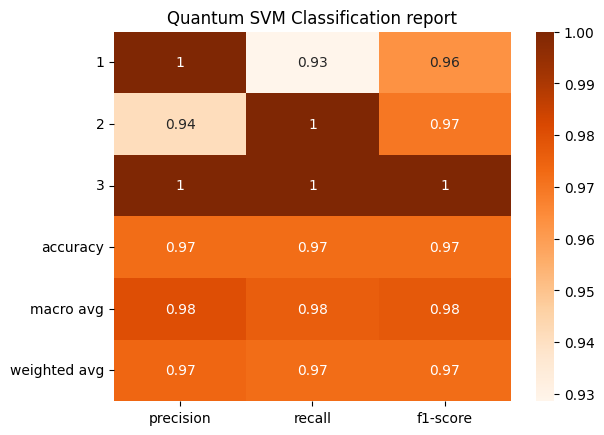

In [39]:
from sklearn.metrics import classification_report
import seaborn as sns

report_quantum = classification_report(y_test, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(report_quantum).iloc[:-1, :].T, annot=True, cmap='Oranges')
plt.title('Quantum SVM Classification report')
plt.show()